In [1]:
from moseq2_viz.model.util import parse_model_results
from moseq2_viz.util import parse_index
from moseq2_viz.scalars.util import scalars_to_dataframe
from scipy import stats
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
# Step 1: load data
#point paths to model and index files
file_path = '/Users/cakiti/Dropbox (Uchida Lab)/Korleki Akiti/Behavior/Standard setup/CombineAnalysis/Just-in-case files/Dataset_20190723/'
#file_path = '/media/alex/DataDrive1/MoSeqData/Dataset_20190723/MoSeq/'

model_file = os.path.join(file_path,'my_model.p') 
index_file = os.path.join(file_path,'moseq2-index.yaml') #generate using "moseq2-viz generate-index"

# load file containing uuids (if only testing subset of data)
uuid_file_path = '/Users/cakiti/Dropbox (Uchida Lab)/Korleki Akiti/Behavior/Standard setup/CombineAnalysis/Dataset_20190723/'
uuid_file_name = os.path.join(uuid_file_path, 'MiceIndex_combine3_uuidN1.csv')
uuid_file      = pd.read_csv(uuid_file_name, header = None)
uuid_file      = uuid_file[0]

#parse index and model results
index, sorted_index = parse_index(index_file)
model_results = parse_model_results(model_file)

#load data to pandas data frame
df = scalars_to_dataframe(sorted_index, include_model = model_file)

display('step 1 done')

'step 1 done'

In [3]:
# Step 2: organize data
#indicate which subject names belong to which experimental group

#stim novelty
group1 = ['Au', 'Ginga', 'Negativa',
'Bishop', 'Knight', 'Rook',
'Appalachian', 'Continental', 'Long']

#cont novelty
group2 = ['Esquiva', 'MeiaLua', 'Queixada',
'King', 'Pawn', 'Queen',
'Arizona', 'JohnMuir', 'Pacific']

#update df to include group labels for associated subject names
for _id in group1:
    df.loc[df.SubjectName==_id, 'group'] = 'group1'
for _id in group2:
    df.loc[df.SubjectName==_id, 'group'] = 'group2'
    
# indicate which uuids belong to which group (index in reference to uuid_file)
which_s = np.array([1, 3, 5, 7, 9, 12, 13, 15, 17])-1
which_c = np.array([2, 4, 6, 8, 10, 11, 14, 16, 18])-1

display('step 2 done')

'step 2 done'

In [4]:
df.head()
#temp = df[['model_label', 'model_label (sort=usage)', 'model_label (sort=frames)']]
#np.savetxt(file_path+'/df_modelLabelAndSortAndFrames.txt', temp, delimiter=',', fmt="%d")

,timestamp,centroid_x_px,centroid_y_px,velocity_2d_px,velocity_3d_px,width_px,length_px,area_px,centroid_x_mm,centroid_y_mm,...,angle,velocity_theta,SessionName,SubjectName,StartTime,group,uuid,model_label,model_label (sort=usage),model_label (sort=frames)
0,1998387576,212.378647,36.431034,0.000000,0.000000,22.593216,45.804768,792.0,-70.662796,-291.870422,...,2.002491,0.000000,session01,King,2019-07-13T13:48:14.3934983-04:00,group2,d0d53474-7d4c-424c-bead-89b0483a1022,-5,-5,-5
1,1998387610,211.958771,36.435844,0.419904,0.553043,22.720619,43.726246,776.0,-71.342957,-291.862427,...,1.999390,3.129838,session01,King,2019-07-13T13:48:14.3934983-04:00,group2,d0d53474-7d4c-424c-bead-89b0483a1022,-5,-5,-5
2,1998387643,211.785110,36.702099,0.317883,0.338353,20.935556,42.675392,702.0,-71.624268,-291.419800,...,2.001822,2.136945,session01,King,2019-07-13T13:48:14.3934983-04:00,group2,d0d53474-7d4c-424c-bead-89b0483a1022,-5,-5,-5
3,1998387676,211.952728,36.642788,0.177802,0.295842,21.149313,43.262562,725.0,-71.352745,-291.518402,...,1.985022,-0.348338,session01,King,2019-07-13T13:48:14.3934983-04:00,group2,d0d53474-7d4c-424c-bead-89b0483a1022,29,72,63
4,1998387710,211.874756,37.614334,0.974670,1.104526,20.096786,44.586239,717.0,-71.479057,-289.903259,...,2.010844,1.648842,session01,King,2019-07-13T13:48:14.3934983-04:00,group2,d0d53474-7d4c-424c-bead-89b0483a1022,29,72,63


In [32]:
# Step 3: compute label usages
def gi(x):
    return ~np.isnan(x).any(tuple(range(1,x.ndim)))
def good(x):
    return x[gi(x)]
def calc_label_usage(labels, n_states=None):
    usage = np.bincount(np.nan_to_num(good(labels)).astype('int32'), minlength=n_states)
    usage = usage / float(usage.sum())
    return usage

N=65 #65
#N=number of syllables to analyze — typically the number of syllables that account for 90% of all behavior

group1_usages = []
for i in df.SubjectName[df.group == 'group1'].unique():
    curr_uuids = df[df.SubjectName == i]['uuid']
    uuid_intersect = curr_uuids.isin(uuid_file[which_s])
    
    working_labels = df[df.SubjectName == i]['model_label (sort=frames)'] 
    working_labels = working_labels[uuid_intersect]             ####################
    working_labels = working_labels[:(30*60*10)]                ####################
    display(working_labels.shape)
    group1_usages.append(calc_label_usage(working_labels[working_labels>-5].values)[:N]) #normalized histcounts
        
    if i == 'Rook':
        print("group 1 mouse 1")
        display(i)
        test=calc_label_usage(working_labels[working_labels>-5].values)[:N]
        display(test.shape)
        
        #np.savetxt(file_path+'/GUsagesStats_workingLabels_G1_sortFrames.txt', working_labels, delimiter=',', fmt="%d")
        #np.savetxt(file_path+'/GUsagesStats_group1Usages_all.txt', group1_usages, delimiter=',', fmt="%.3f")
    
group2_usages = []
for i in df.SubjectName[df.group == 'group2'].unique():
    curr_uuids = df[df.SubjectName == i]['uuid']
    uuid_intersect = curr_uuids.isin(uuid_file[which_c])
    
    working_labels = df[df.SubjectName == i]['model_label (sort=frames)']
    working_labels = working_labels[uuid_intersect]             ####################
    working_labels = working_labels[:(30*60*10)]                ####################
    group2_usages.append(calc_label_usage(working_labels[working_labels>-5].values)[:N])
        
    if i == 'King':
        print("group 2 mouse 1")
        display(working_labels.shape)
        
display('step 3 done')

#display(df.SubjectName[df.group == 'group1'].unique())
#display(df.SubjectName[df.group == 'group2'].unique())
# group1_usages shape = 9 x 65

(18000,)

group 1 mouse 1


'Rook'

(65,)

(18000,)

(18000,)

(18000,)

(18000,)

(18000,)

(18000,)

(18000,)

(18000,)

group 2 mouse 1


(18000,)

'step 3 done'

In [33]:
temp = np.array([0, 1, 1, 3, 2, 1, 7, 20])
display(temp[temp>0])
np.bincount(temp)

array([ 1,  1,  3,  2,  1,  7, 20])

array([1, 3, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [34]:
# Step 4: bootstrap usages
def bootstrap_group(lst, rng):
    return list(rng.choice(len(lst),len(lst),replace=True))

def bootstrap_me(usages, iters=1000):
    bootstrap_mean_usages = []
    for i in range(iters):
        rng = np.random.RandomState(seed=i)
        temp = []
        boot_mice = bootstrap_group(usages, rng)
        for mouse in boot_mice:
            temp.append(usages[mouse])

        #if i == 0:
            #display(i)
            #np.savetxt(file_path+'/bootstrap_temp.txt', temp, delimiter=',', fmt="%s")
                
        temp = np.asarray(temp) 
        bootstrap_mean_usages.append(np.nanmean(temp,axis=0))
        
    return bootstrap_mean_usages

group1_boots = bootstrap_me(group1_usages)
group2_boots = bootstrap_me(group2_usages)
#display(np.shape(group1_boots))

display('step 4 done')

'step 4 done'

In [35]:
# Step 5: perform z-test
# A z-test is a statistical test to determine whether two population means are different
# when the variances are known and the sample size is large.
# It can be used to test hypotheses in which the z-test follows a normal distribution.
def ztest(d1, d2, mu1=None, mu2=None):
    mu1 = d1.mean() if mu1 is None else mu1
    mu2 = d2.mean() if mu2 is None else mu2
    std1, std2 = d1.std(), d2.std()

    std = np.sqrt(std1**2 + std2**2)
    return np.minimum(1.,2*stats.norm.cdf(-np.abs(mu1 - mu2)/std))

# do a ztest on the bootstrap distributions of your 2 conditions
group1_boots = np.asarray(group1_boots)
group2_boots = np.asarray(group2_boots)

#pvals_ztest_boots = np.array([ztest(group1_boots[:,i], group2_boots[:,i]) for i in range(group1_boots.shape[1])])
pvals_ztest_boots = np.array([ ztest(group1_boots[:,i], group2_boots[:,i]) for i in range(np.shape(group1_boots)[1]) ])

#np.savetxt(file_path+'/pvals_ztest_boots_N1_10min.txt', pvals_ztest_boots, delimiter=',', fmt="%.6f")

display('step 5 done')

'step 5 done'

In [36]:
# Step 6: multiple comparisons p-value correction
from statsmodels.stats.multitest import multipletests

# correction method = fdr_bh = Benjamini/Hochberg (non-negative) 
# significant syllables (relabeled by time used)
sig_syls = np.where(multipletests(pvals_ztest_boots, alpha=0.10, method='fdr_bh')[0])[0]
display(sig_syls)

#multipletests output:
# boolean (true=significant)
# pvals_corrected
# corrected alpha for Sidak method
# corrected alpha for Bonf method

after_correction = multipletests(pvals_ztest_boots, alpha=0.10, method='fdr_bh') #'fdr_bh','holm'
display(after_correction)
#np.savetxt(file_path+'/pvals_afterCorrection_bool_N1_10min.txt', after_correction[1], delimiter=',', fmt="%.6f")

display('step 6 done')

array([53])

(array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False,  True,
        False, False, False, False, False, False, False, False, False,
        False, False]),
 array([0.98720715, 0.98720715, 0.98107199, 0.96919204, 0.96919204,
        0.96919204, 0.99938972, 0.96919204, 0.96919204, 0.99938972,
        0.96919204, 0.96919204, 0.96919204, 0.98720715, 0.84682025,
        0.96919204, 0.96919204, 0.96919204, 0.96919204, 0.98720715,
        0.96919204, 0.96919204, 0.96919204, 0.98720715, 0.99938972,
        0.98720715, 0.98107199, 0.99938972, 0.98720715, 0.3234506 ,
        0.98107199, 0.99938972, 0.96919204, 0.96919204, 0.96919204,
   

'step 6 done'

In [48]:
#display(multipletests(pvals_ztest_boots, alpha=0.35, method='fdr_bh'))
#display(np.where(multipletests(pvals_ztest_boots, alpha=0.35, method='fdr_bh')[0])[0])

(array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False,  True,
        False, False, False, False, False, False, False, False,  True,
        False, False]),
 array([0.98720715, 0.98720715, 0.98107199, 0.96919204, 0.96919204,
        0.96919204, 0.99938972, 0.96919204, 0.96919204, 0.99938972,
        0.96919204, 0.96919204, 0.96919204, 0.98720715, 0.84682025,
        0.96919204, 0.96919204, 0.96919204, 0.96919204, 0.98720715,
        0.96919204, 0.96919204, 0.96919204, 0.98720715, 0.99938972,
        0.98720715, 0.98107199, 0.99938972, 0.98720715, 0.3234506 ,
        0.98107199, 0.99938972, 0.96919204, 0.96919204, 0.96919204,
   

array([8.62077748e-01, 8.09516352e-01, 5.51484808e-01, 5.01393783e-01,
       4.60741690e-01, 4.68945783e-01, 9.69624300e-01, 2.42831237e-01,
       2.61662130e-01, 9.65963825e-01, 4.95197858e-01, 5.19262975e-01,
       4.30830119e-01, 8.86512795e-01, 5.21120154e-02, 3.38913912e-01,
       1.76403868e-01, 5.21872637e-01, 4.50172017e-01, 6.46824324e-01,
       3.22635702e-01, 1.03358601e-01, 1.10788129e-01, 7.28923175e-01,
       9.89890784e-01, 8.94842513e-01, 5.91125326e-01, 9.94708396e-01,
       7.28042332e-01, 1.49284890e-02, 6.08277847e-01, 9.99389722e-01,
       2.67942891e-01, 3.41865328e-01, 2.22697496e-01, 4.29213381e-01,
       7.28979710e-01, 8.74111595e-01, 4.80158319e-01, 2.07127828e-01,
       8.88759612e-01, 6.57172801e-01, 3.52765585e-01, 2.54768447e-01,
       3.22062831e-01, 6.12597572e-01, 2.76094013e-01, 2.14850849e-01,
       8.60081917e-01, 8.97926790e-01, 4.71463534e-01, 2.51225213e-01,
       6.18830024e-01, 2.71548705e-05, 5.67770119e-01])

(array([  4.,  13.,  53., 116., 230., 271., 186.,  98.,  26.,   3.]),
 array([0.00570465, 0.00708081, 0.00845697, 0.00983312, 0.01120928,
        0.01258543, 0.01396159, 0.01533774, 0.0167139 , 0.01809005,
        0.01946621]),
 <a list of 10 Patch objects>)

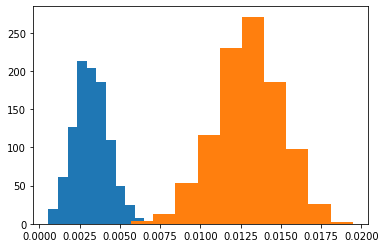

In [30]:
display(pvals_ztest_boots)

# significant syllable(s)
curr_syl = 53

# histogram of the sampling distribution of the means for each group
plt.hist(group1_boots[:,curr_syl])
plt.hist(group2_boots[:,curr_syl])

In [ ]:
def _ecdf(x):
    '''no frills empirical cdf used in fdrcorrection
    '''
    nobs = len(x)
    return np.arange(1,nobs+1)/float(nobs)

p_vals_ex = [0.000027, 0.012836, 0.014928, 0.052112, 0.103359, 0.110788]
display(len(p_vals_ex))
display(np.arange(1,len(p_vals_ex)+1))
display(float(len(p_vals_ex)))

display(_ecdf(p_vals_ex))